# Auswertung KITAplus Umfrage

Dieses Notebook dient dazu meine Auswertung zu machen.

## Funktionen und Module definieren

In [1]:
# Load Modules.
import csv
import math
import json
from scipy.stats import spearmanr
import itertools
from statistics import mean
import random
from datetime import datetime

def saveJSON(obj, filePath):
    with open(filePath, "w") as fp:
        json.dump(obj, fp, sort_keys=True, indent=2, ensure_ascii=False)
        print(f"Saved JSON to: {filePath}")

def loadJSON(filePath):
    with open(filePath, "rb") as fp:
        print(f"Load JSON from: {filePath}")
        return json.load(fp)

## Lade CSV (unused)

In [2]:
def loadCSV(file):
    with open(file) as fp:
        reader = csv.reader(fp, quotechar='"', delimiter=",")
        
        data = []
        for row in reader:
            data.append(row)
        
        return data

# csvData = loadCSV("./Kitaliste.csv")
# print(csvData)

def csvToJSON(csvData):
    data = {
        "ids" : [],
        "ansPerPerson" : [],
        "ansPerQuestion" : {}
    }

    data["ids"] = csvData[1]
    ansPerPerson = csvData[2:]

    for personRow in ansPerPerson:
        personData = {}
        for id, zellenWert in zip(data["ids"], personRow):
            personData[id] = zellenWert

    data["ansPerPerson"].append(personData)

    return data

## Postprocessing

In [3]:
def convertToNumber(value, type, defaultValueRepl, defaultValue=""):
    if value == defaultValue:
        return defaultValueRepl
    else:
        return type(value)

def splitToList(s, type, delimiter=",", sort=True):
    if s == "":
        return []

    splitted = s.split(delimiter)
    l = [ type(v.strip()) for v in splitted ]

    if sort:
        return sorted(l)
    else:
        return l

def convertToYears(s):
    splitted = splitToList(s, float, delimiter=";", sort=False)
    return splitted[0] + (splitted[1] / 12)

def convertToYearAndMonths(years):
    nYears = math.trunc(years)
    rest = years - nYears 
    return [nYears, round(rest * 12)]

def convertToBool(s, trueValue, falseValue, emptyIsNone=False):
    if s == trueValue:
        
        return True
    elif s == falseValue:
        return False
    elif emptyIsNone and s == "":
        return None
    else:
        raise ValueError(f"Text '{s}' is nicht '{trueValue}' " + 
            f"und auch nicht '{falseValue}'")

# Input: s = "2013/n, 2015/n, ?/j"
# Output: [ [2013,False], [2015,False], [None,True] ]
def convertToSiblingList(s):
    if s.strip() == "n": 
        return []
    elif s.strip() == "":
        return None

    siblings = splitToList(s, str, sort=False)

    l = []
    for sib in siblings:
        res = splitToList(sib, str, delimiter="/", sort=False)
        if len(res) != 2:
            raise ValueError(f"Siblings '{siblings}' has errors.")

        birthyear = res[0]
        hasKita = res[1]

        birthyear = convertToNumber(birthyear, int, None, defaultValue="?")
        hasKita = convertToBool(hasKita,"j","n")
        l.append( [birthyear, hasKita] )
    
    return sorted(l)

# Input: s = "J/1,2,4"
# Output: [ True, [1,2,4] ]
def convertToVorHFE(s):
    if s == "":
        return []
    jaNein, lst = splitToList(s, str, delimiter="/", sort=False)
    return [ convertToBool(jaNein, "J", "N"), splitToList(lst, int) ]

def mapToValues(s, dic, defaultValue=None):
    if s == "":
        return defaultValue

    if not s in dic:
        raise ValueError(f"Value '{s}' is not in dict '{dic}'.")
        
    return dic[s]

def convertToDate(s):
    if s is None:
        return s
    return datetime.strptime(s, "%d.%m.%Y")


In [4]:
data = loadJSON("AuswertungInput.json")

# Antworten jeder Person bereinigen.
for answers in data["ansPerPerson"]:
    
    answers["tage"] = convertToNumber(answers["tage"], float, 0)
    answers["indik"] = convertToNumber(answers["indik"], int, None)
    answers["indikHFE"] = splitToList(answers["indikHFE"], int)
    answers["hGrund"] = convertToNumber(answers["hGrund"], int, None)
    
    answers["hatHFE"] = convertToBool(answers["hatHFE"], 
                                      trueValue="", 
                                      falseValue="keine")
    
    answers["1zu1Betr"] = convertToBool(answers["1zu1Betr"], 
                                        trueValue="j", 
                                        falseValue="n", 
                                        emptyIsNone=True)

    answers["grund"] = splitToList(answers["grund"], int)
    answers["finanz"] = splitToList(answers["finanz"], int)

    if (2 in answers["finanz"] or 6 in answers["finanz"]) and \
        (1 in answers["finanz"]):
        i = answers["initialen"]
        print(f"Entferne Grund Eltern von {i} ...")
        answers["finanz"].remove(1)

    answers["erstsprache"] = splitToList(answers["erstsprache"], int)
    answers["alter"] = convertToYears(answers["alter"])
    answers["geschwister"] = convertToSiblingList(answers["geschwister"])

    answers["suppKPlus"] = convertToNumber(answers["suppKPlus"], int, None)

    answers["suppHFE"] = splitToList(answers["suppHFE"], int)
    if len(answers["suppHFE"]) == 0:
        answers["suppHFE"] = None
        
    answers["beeinGrad"] = mapToValues(answers["beeinGrad"], 
        {"l" : 1, "m" : 2, "s": 3}, defaultValue=None)

    answers["kitaVorHFE"] = convertToVorHFE(answers["kitaVorHFE"])

saveJSON(data, "Auswertung.json")


Load JSON from: AuswertungInput.json
Entferne Grund Eltern von TE ...
Entferne Grund Eltern von SD ...
Entferne Grund Eltern von HD ...
Entferne Grund Eltern von KE ...
Entferne Grund Eltern von KS ...
Entferne Grund Eltern von LB ...
Entferne Grund Eltern von RB ...
Entferne Grund Eltern von MI ...
Entferne Grund Eltern von AS ...
Entferne Grund Eltern von AM ...
Entferne Grund Eltern von FM ...
Saved JSON to: Auswertung.json


## Speichere Antworten zu jeder Frage (Id)

In [5]:
data["ansPerQuestion"] = {}

ids = set()
for ansPerson in data["ansPerPerson"]:
    ids.update(ansPerson.keys())

data["ids"] = sorted(list(ids))

for id in ids:
    # print(f"Speichere Antworten für id {id}")

    answers = []
    for ansPerson in data["ansPerPerson"]:
        if id in ansPerson: 
            answers.append(ansPerson[id])

    # print(f" - Antworten: {answers[0:3]}...")

    data["ansPerQuestion"][id] = answers

saveJSON(data, "Auswertung.json")

Saved JSON to: Auswertung.json


## Plot Setup

/var/folders/2l/9h656ymn2f1ddsym225wf6fr0000gn/T/ipykernel_20091/396314546.py:10: UserWarning: Style includes a parameter, 'backend', that is not related to style.  Ignoring this parameter.
  plt.style.use("style.mplstyle")


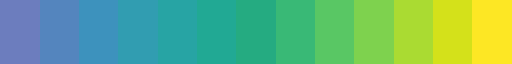

In [6]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap 
import seaborn as sns
import colorsys

plt.style.use("style.mplstyle")
%matplotlib widget

preamble = "\n".join([
    r'\usepackage{fontspec}',
    r'\usepackage{amsmath,amssymb}',
    r'\usepackage{lmodern}',
    r'\usepackage{unicode-math}',
    r'\defaultfontfeatures{Scale=MatchLowercase}',
    r'\defaultfontfeatures[\rmfamily]{Ligatures=TeX,Scale=1}',
    r'\setmainfont[]{Latin Modern Roman}',
    r'\setsansfont[]{Latin Modern Sans}',
    r'\setmonofont[]{Latin Modern Mono}',
    r'\setmathfont[]{Latin Modern Math}'
])

params = {
    'font.family': 'sans',
    'text.usetex': False,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'xelatex',
    'pgf.preamble': preamble,
}

from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
mpl.rcParams.update(params)

def makeFigSize(w, h):
    return w/2.54 , h/2.54

def makeFigure(figsize=makeFigSize(7.8, 8), *args, **kwargs):
    fig, ax = plt.subplots(figsize=figsize, 
        constrained_layout=True, *args, **kwargs)
    ax.title.set_fontfamily("Latin Modern Sans")
    return fig, ax

def saveFig(fig, file):
    fig.savefig(file, backend="pgf", bbox_inches='tight')
    pass

lightenDef = [1.5, 1.0]
saturationDef = [1.0, 1.0]

def scaleLightness(rgba, ratio, lts=lightenDef, sats=saturationDef):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgba[0:3])
    
    ltsMax = 0.5
    if ratio <= ltsMax:
        ratio = 1/ltsMax*ratio
        lt = (1-ratio)*lts[0] + ratio*lts[1] 
        sat = (1-ratio)*sats[0] + ratio*sats[1] 
    else:
        lt = 1
        sat = 1
         
    # manipulate h, l, s values and return as rgb
    l= min(1, l * lt)
    s = min(1, s * sat)
    return (*colorsys.hls_to_rgb(h,l,s), rgba[3])

def getColorMap(nColors, lts=lightenDef, sats=saturationDef, start=3/13, shuffle=0):
    c = sns.color_palette("viridis", as_cmap=True)
    cs = []
    for i in range(0, nColors):
        ratio01 = i/(nColors-1)
        ratio = i/(nColors-1) * (1-start) + start
        cs.append(
            scaleLightness(c(ratio), ratio01, lts=lts, sats=sats)
        )
    if shuffle:
        random.Random(shuffle).shuffle(cs)
    return cs
def adjustPie(fig, ax, leg, right=0.6):
    ax.set_xlim(-1.0,1.0)
    ax.set_ylim(-1.0,1.0)
    fig.subplots_adjust(right=right)
    fig.tight_layout(pad=0.5)

defaultColor = getColorMap(10)[1]

ticksRotation = {
    "rotation" : -30, 
    "ha" : "left", 
    "rotation_mode" : "anchor"}

withTitle = False

ListedColormap(getColorMap(13, start=3/13, lts=[1.5,1.0], shuffle=0))


## Erstsprache vs. Finanzierung

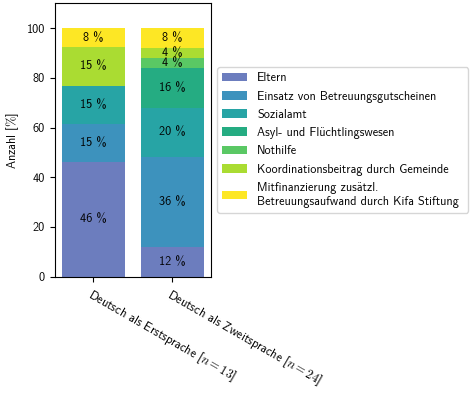

In [18]:
xValues = data["ansPerQuestion"]["erstsprache"]
yValues = data["ansPerQuestion"]["finanz"]

values = zip(xValues,yValues)
def onlyValid(e):
    return e[0] is not None and e[1] is not None

values = list(filter(onlyValid, values))

counts = np.zeros(shape=(7,2)) 
nPerSprache = [0,0]

for sprachen, finanzen in values:
    sp = 0 if 1 in sprachen else 1
    
    nPerSprache[sp] += 1

    for fi in finanzen:
        counts[fi-1,sp] += 1
        counts[fi-1,sp] += 1 # Gesamt.

nPerBar = np.ndarray.sum(counts, axis=0)
percentage = counts / nPerBar * 100
n = len(values)

fig, ax = makeFigure(figsize=makeFigSize(12,10))
colors = getColorMap(7)
x = [1,2]

for fi in range(0,7):
    p = ax.bar(x, percentage[fi], width=0.8, 
           bottom=np.ndarray.sum(percentage[0:fi], axis=0),
           color=colors[fi],
           label=data["finanzKlassen"][str(fi+1)])

    labels = [ (f"{v:.0f} %" if v else "") for v in percentage[fi] ]
    ax.bar_label(p, label_type='center',labels=labels, fontsize=9.0, rotation=0)

ax.set_ylabel('Anzahl [$\%$]')
ax.set_ylim((0,110))

if withTitle:
    ax.set_title(f'Erstsprache vs.\nFinanzierung des Kindes [$n={n}$]')
ax.set_xticks(x, labels=[
    f'Deutsch als Erstsprache [$n={nPerSprache[0]}$]', 
    f'Deutsch als Zweitsprache [$n={nPerSprache[1]}$]'], **ticksRotation)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

saveFig(fig, "ErstspracheVsFinanzierung.pdf")


[5, 8, 1, 1, 1, 11, 2, 2, 12, 4, 4, 3, 4, 12, 1, 14, 8, 12, 12, 2, 5, 14, 14, 1, 14, 12, 12, 13, 1, 14, 12, 8, 14, 14, 8]


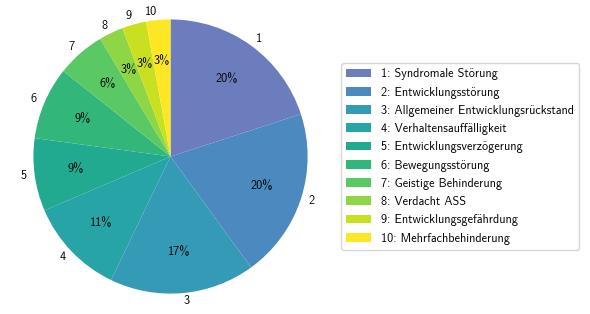

In [19]:
xValues = list(filter(lambda x: x is not None, data["ansPerQuestion"]["indik"]))

print(xValues)
count = {}
for x in xValues:
    if x not in count:
        count[x] = 0
    count[x] += 1

count = sorted(list(count.items()), key=lambda x: x[1], reverse=True)

labels = [ data["indikHFHKlassen"][str(indik)] for indik, _ in count ]
labels = [ f"{i+1}: {l}" for i, l in enumerate(labels)]

xValues = [ c for _, c in count ]
colors = getColorMap(len(xValues))

fig, ax = makeFigure(figsize=makeFigSize(15.0,8))
fig.set_constrained_layout(False)
ax.pie(xValues, colors=colors, 
       labels=range(1,len(xValues)+1), labeldistance=1.06, 
       startangle=90, counterclock=False,
       autopct = '%.0f%%', pctdistance=0.7, textprops={'fontsize': 9})

if withTitle:
    ax.set_title(f'Inidikation für Heilpäd. Früherziehung')

leg = ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1.1, 0.5))
adjustPie(fig,ax,leg)

saveFig(fig, "IndikationKPlus.pdf")

## Indikation KITAplus vs Unterstützungsbedarf

[([12], 2), ([10], 3), ([1, 7, 9], 3), ([1], 3), ([2, 7, 8, 9, 11], 3), ([7, 11], 4), ([1, 11], 4), ([1, 5], 3), ([15], 4), ([1], 2), ([1, 4], 3), ([1, 2, 3, 9], 3), ([], 3), ([8, 11], 3), ([], 2), ([1, 4, 5, 6, 9], 4), ([1, 7, 8, 9], 2), ([], 2), ([5, 10], 3), ([5, 10], 3), ([1, 7, 8], 3), ([10], 3), ([1, 6, 12], 4), ([12], 3), ([], 3), ([1, 2, 3, 4, 7, 8, 9, 11], 3), ([1, 7, 9, 10], 4), ([1, 6, 12], 4), ([8, 9], 3), ([1, 7, 8, 9, 10], 4), ([1, 7, 8, 9, 10], 4), ([7, 8, 9], 3)]
[[2. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
 [7. 3. 2. 2. 3. 0. 5. 6. 6. 4. 3. 1. 0. 0. 0.]
 [7. 0. 0. 1. 1. 3. 4. 2. 4. 3. 2. 2. 0. 0. 1.]]


/var/folders/2l/9h656ymn2f1ddsym225wf6fr0000gn/T/ipykernel_26240/3835777710.py:22: RuntimeWarning: invalid value encountered in true_divide
  percentage = counts / nPerBar * 100


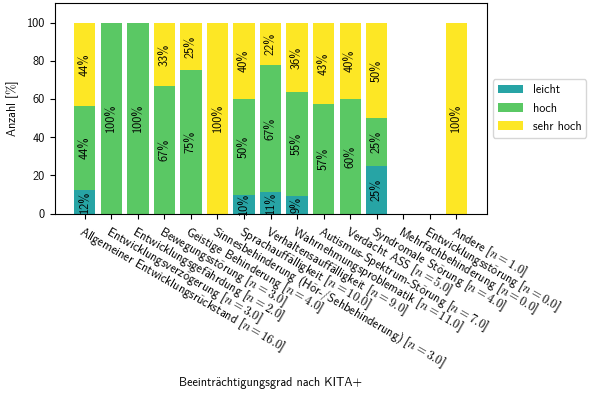

In [20]:
xValues = data["ansPerQuestion"]["indikHFE"]
yValues = data["ansPerQuestion"]["suppKPlus"]

values = zip(xValues,yValues)

def onlyValid(e):
    return e[0] is not None and e[1] is not None

values = list(filter(onlyValid, values))

nIndiks=15
counts = np.zeros(shape=(4,nIndiks)) 
print(values)
for indik, sKP in values:
    for i in indik:
        counts[sKP-1,i-1] += + 1

# Slicen um die Nullerkolonnen wegzukriegen
print(counts[1:,:])

nPerBar = np.ndarray.sum(counts, axis=0)
percentage = counts / nPerBar * 100
n = len(values)

fig, ax = makeFigure(figsize=makeFigSize(15.0,10))
colors = getColorMap(4)
x = list(range(1,nIndiks+1))

for suppKP in range(1,4):
    p = ax.bar(x, percentage[suppKP], width=0.8, 
           bottom=np.ndarray.sum(percentage[0:suppKP], axis=0),
           color=colors[suppKP],
           label=data["supportKPlusKlassen"][str(suppKP+1)])

    labels = [ (f"{v:.0f}%" if v else "") for v in percentage[suppKP] ]
    ax.bar_label(p, label_type='center',labels=labels, fontsize=9.0, rotation=90)

ax.set_ylabel('Anzahl [$\%$]')
ax.set_xlabel('Beeinträchtigungsgrad nach KITA+')
ax.set_ylim((0,110))

if withTitle:
    ax.set_title(f'Unterstützungsbedarf vs.\nBeeinträchtigung des Kindes [$n={n}$]')

ax.set_xticks(x, labels=[
    f'{data["indikHFHKlassen"][str(i+1)]} [$n={nPerBar[i]}$]' for i in range(nIndiks)], **ticksRotation)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

saveFig(fig, "IndikationVsSuppKPlus.pdf")

# Alterverteilung

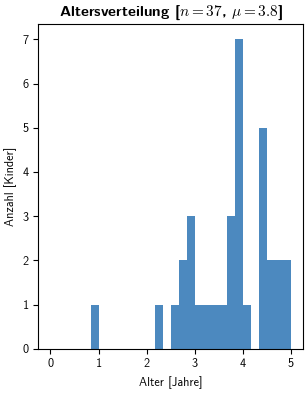

In [21]:
x = data["ansPerQuestion"]["alter"]
startEnd=(0,5)
n = len(x)
bins = (startEnd[1]-startEnd[0])*6
mn = mean(x)

fig, ax = makeFigure(figsize=makeFigSize(7.8, 10))
ax.hist(x, bins, color=defaultColor, range=startEnd, histtype='bar')

#if withTitle:
ax.set_title(f"Altersverteilung [$n={n}$, $\mu={mn:.1f}$]", fontfamily="Latin Modern Sans")
ax.set_xlabel("Alter [Jahre]")
ax.set_ylabel("Anzahl [Kinder]")

labels = range(startEnd[0],startEnd[1]+1)
ax.set_xticks(labels)
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 1))

saveFig(fig, "Altersverteilung.pdf")

## Tagesverteilung

[1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 2.0, 3.0, 1.0, 2.0, 2.0, 4.0, 0, 0, 0, 0, 2.0, 1.0, 0.5, 3.0, 3.0, 1.0, 1.0, 1.0, 3.0, 3.0, 4.0, 4.0, 2.0, 2.0, 1.5, 2.5, 3.0, 2.0, 2.0, 3.0]
1.9054054054054055


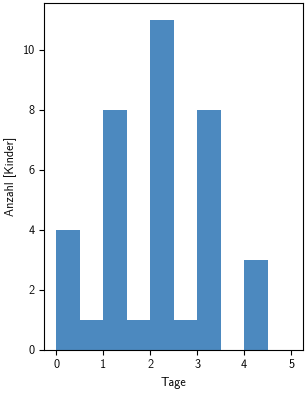

In [22]:
# Tagesverteilung
x = data["ansPerQuestion"]["tage"]
print(x)
startEnd=(0,5)
n = len(x)
bins = (startEnd[1]-startEnd[0])*2
mn = mean(x)

fig, ax = makeFigure(makeFigSize(7.8,10))
ax.hist(x, bins, color=defaultColor, range=startEnd, align='mid', histtype='bar')

if withTitle:
    ax.set_title(f"Anzahl Tage in der Kita\n[$n={n}$, $\mu={mn:.1f}$]", fontfamily="Latin Modern Sans")
ax.set_xlabel("Tage")
ax.set_ylabel("Anzahl [Kinder]")

labels = range(startEnd[0],startEnd[1]+1)
ax.set_xticks(labels,labels);
saveFig(fig, "Tagesverteilung.pdf")

print(mn)

## Anzahl Tage im Vergleich mit hohem und sehr hohem Unterstützungsbedarf

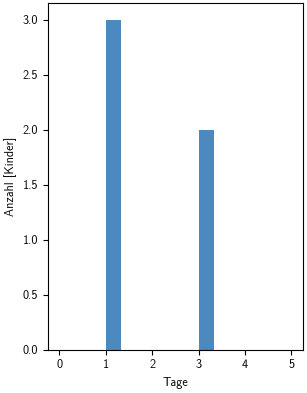

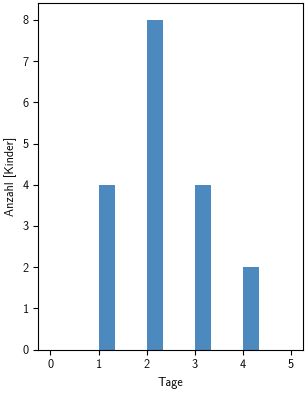

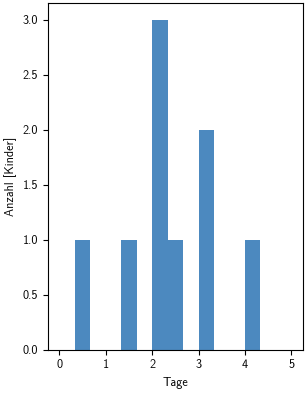

In [23]:
x = data["ansPerQuestion"]["tage"]
suppKP = data["ansPerQuestion"]["suppKPlus"]

pairs = list(zip(x, suppKP))

for suppKP, adj in zip([2,3,4], ["leicht", "hoch", "sehr hoch"]):
    x = [ t for t, s in filter(lambda v: v[1] == suppKP , pairs) ]

    startEnd=(0,5)
    n = len(x)
    bins = (startEnd[1]-startEnd[0])*3
    mn = mean(x)

    fig, ax = makeFigure(makeFigSize(7.8,10))
    ax.hist(x, bins, color=defaultColor, range=startEnd, align='mid', histtype='bar')

    if withTitle:
        ax.set_title(f"Anzahl Tage in der Kita \nmit {adj} Unterstützungsbedarf\n[$n={n}$, $\mu={mn:.1f}$]", fontfamily="Latin Modern Sans")
    ax.set_xlabel("Tage")
    ax.set_ylabel("Anzahl [Kinder]")

    labels = range(startEnd[0],startEnd[1]+1)
    ax.set_xticks(labels,labels)
    saveFig(fig, f"TagesverteilungNurSupp-{suppKP}.pdf")

## KITAplus: Beeinträchtigung versus Unterstützungsbedarf  

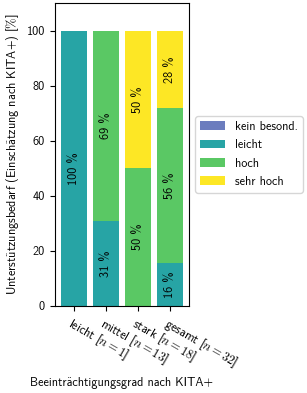

In [24]:
xValues = data["ansPerQuestion"]["beeinGrad"]
yValues = data["ansPerQuestion"]["suppKPlus"]

values = zip(xValues,yValues)

def onlyValid(e):
    return e[0] is not None and e[1] is not None

values = list(filter(onlyValid, values))

counts = np.array([[0,0,0,0],   # keiner
                   [0,0,0,0],   # leicht
                   [0,0,0,0],   # hoch
                   [0,0,0,0]])  # sehr hoch
#                   m l s gesamt

for bG, sKP in values:
    counts[sKP-1,bG-1] += + 1
    counts[sKP-1,3] += 1 # Gesamt.

nPerBar = np.ndarray.sum(counts, axis=0)
percentage = counts / nPerBar * 100
n = len(values)

fig, ax = makeFigure(figsize=makeFigSize(7.8,10))
colors = getColorMap(4)
x = [1,2,3,4]

for suppKP in range(0,4):
    p = ax.bar(x, percentage[suppKP], width=0.8, 
           bottom=np.ndarray.sum(percentage[0:suppKP], axis=0),
           color=colors[suppKP],
           label=data["supportKPlusKlassen"][str(suppKP+1)])

    labels = [ (f"{v:.0f} %" if v else "") for v in percentage[suppKP] ]
    ax.bar_label(p, label_type='center',labels=labels, fontsize=9.0, rotation=90)

ax.set_ylabel('Unterstützungsbedarf (Einschätzung nach KITA+) [$\%$]')
ax.set_xlabel('Beeinträchtigungsgrad nach KITA+')
ax.set_ylim((0,110))

if withTitle:
    ax.set_title(f'Unterstützungsbedarf vs.\nBeeinträchtigung des Kindes [$n={n}$]')
ax.set_xticks(x, labels=[
    f'leicht [$n={nPerBar[0]}$]', 
    f'mittel [$n={nPerBar[1]}$]', 
    f'stark [$n={nPerBar[2]}$]',
    f'gesamt [$n={nPerBar[3]}$]'], **ticksRotation)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

saveFig(fig, "BeinträchtigungsgradVsSuppKPlus.pdf")

# Beinträchtigung versus Geschlecht

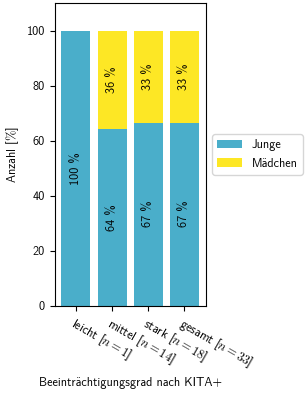

In [25]:
xValues = data["ansPerQuestion"]["beeinGrad"]
yValues = data["ansPerQuestion"]["geschlecht"]

values = zip(xValues,yValues)
values = list(filter(onlyValid, values))

counts = np.array([[0,0,0,0],   # mann
                   [0,0,0,0]])  # frau
#                   m l s gesamt

for bG, gesch in values:
    geschIdx = 0 if gesch == "m" else 1
    counts[geschIdx,bG-1] += 1
    counts[geschIdx,3] += 1 # Gesamt.

nPerBar = np.ndarray.sum(counts, axis=0)
percentage = counts / nPerBar * 100
n = len(values)

fig, ax = makeFigure(figsize=makeFigSize(7.8,10))
colors = getColorMap(2, start=0.4)
x = [1,2,3,4]

geschlechter = ["Junge", "Mädchen"]

for geschlIdx in range(0,2):
    p = ax.bar(x, percentage[geschlIdx], width=0.8, 
           bottom=np.ndarray.sum(percentage[0:geschlIdx], axis=0),
           color=colors[geschlIdx],
           label=geschlechter[geschlIdx])

    labels = [ (f"{v:.0f} %" if v else "") for v in percentage[geschlIdx] ]
    ax.bar_label(p, label_type='center',labels=labels, fontsize=9.0, rotation=90)

ax.set_ylabel('Anzahl [$\%$]')
ax.set_xlabel('Beeinträchtigungsgrad nach KITA+')
ax.set_ylim((0,110))

if withTitle:
    ax.set_title(f'Beinträchtigung vs.\nGeschlecht des Kindes [$n={n}$]')
ax.set_xticks(x, labels=[
    f'leicht [$n={nPerBar[0]}$]', 
    f'mittel [$n={nPerBar[1]}$]', 
    f'stark [$n={nPerBar[2]}$]',
    f'gesamt [$n={nPerBar[3]}$]'], **ticksRotation)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

saveFig(fig, "BeinträchtigungsgradVsMannFrau.pdf")

# Vergleich: Unterstüztungsbedarf HFE und KITAplus

{(2, 2): 2.5, (3, 3): 9.5, (4, 4): 4.0, (3, 4): 4.0, (4, 3): 3.0, (2, 3): 3.5, (2, 4): 1.0, (3, 2): 0.5}


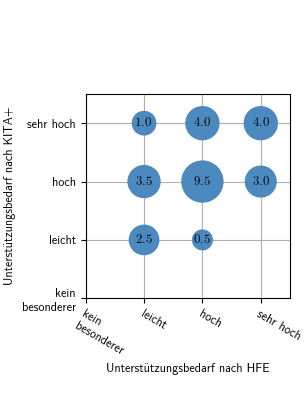

In [26]:
xValues = data["ansPerQuestion"]["suppHFE"]
yValues = data["ansPerQuestion"]["suppKPlus"]

values = list(zip(xValues,yValues))

def onlyValid(e):
    return e[0] is not None and e[1] is not None

values = list(filter(onlyValid, values))

distinctP = dict()

for suppHFEs, suppKP in values:
    for suppHFE in suppHFEs:
        point = (suppHFE, suppKP)
        if point not in distinctP:
            distinctP[point] = 0.0

        distinctP[point] += 1.0/len(suppHFEs)

print(distinctP)

pointsX=[]
pointsY=[]
count=[]
for v, c in distinctP.items():
    pointsX.append(v[0])
    pointsY.append(v[1])
    count.append(c)

count = np.array(count)
n = len(values)
spearmanCorr, _ = spearmanr(pointsX, pointsY)


fig, ax = makeFigure(figsize=makeFigSize(7.8,10))
ax.scatter(pointsX, pointsY, s=500*np.sqrt(count/math.pi), color=defaultColor)
ax.set_xlim((1,4.5))
ax.set_ylim((1,4.5))
ax.set_aspect("equal")
ax.set_axisbelow(True)
ax.grid(True)

for i, count in enumerate(count):
    ax.annotate(count, (pointsX[i], pointsY[i]), 
                horizontalalignment="center", verticalalignment="center", fontsize=9, usetex=True)

x=[1,2,3,4]

if withTitle:
    ax.set_title(f'Unterstützungsbedarf HFE vs.\nUnterstützungsbedarf KITA+ [$n={n}, \\rho={spearmanCorr:0.2f}$]')
l = [
    f'kein\nbesonderer', 
    f'leicht', 
    f'hoch',
    f'sehr hoch']
ax.set_xticks(x, labels=l, **ticksRotation)
ax.set_yticks(x, labels=l)

ax.set_xlabel('Unterstützungsbedarf nach HFE')
ax.set_ylabel('Unterstützungsbedarf nach KITA+')

saveFig(fig, "UnterstützungsbedarfHFEVsKPlus.pdf")

## Beinträchtigung versus 1zu1 Betreuung

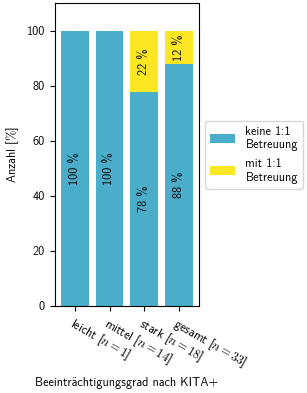

In [27]:
xValues = data["ansPerQuestion"]["beeinGrad"]
yValues = data["ansPerQuestion"]["1zu1Betr"]

values = zip(xValues,yValues)
values = list(filter(onlyValid, values))

counts = np.array([[0,0,0,0],   # keine
                   [0,0,0,0]])  # mit Betreuung
#                   m l s gesamt

for bG, betr in values:
    betrIdx = 1 if betr else 0
    counts[betrIdx,bG-1] += 1
    counts[betrIdx, 3] += 1 # Gesamt.

nPerBar = np.ndarray.sum(counts, axis=0)
percentage = counts / nPerBar * 100
n = len(values)

fig, ax = makeFigure(figsize=makeFigSize(7.8,10))
colors = getColorMap(2, start=0.4)
x = [1,2,3,4]

betreuung = ["keine 1:1\nBetreuung", "mit 1:1\nBetreuung"]

for betr in range(0,2):
    p = ax.bar(x, percentage[betr], width=0.8, 
           bottom=np.ndarray.sum(percentage[0:betr], axis=0),
           color=colors[betr],
           label=betreuung[betr])

    labels = [ (f"{v:.0f} %" if v else "") for v in percentage[betr] ]
    ax.bar_label(p, label_type='center',labels=labels, fontsize=9.0, rotation=90)

ax.set_ylabel('Anzahl [$\%$]')
ax.set_xlabel('Beeinträchtigungsgrad nach KITA+')
ax.set_ylim((0,110))

if withTitle:
    ax.set_title(f'Beeinträchtigung vs.\n1:1 Betreuung [$n={n}$]')
ax.set_xticks(x, 
    labels=[
        f'leicht [$n={nPerBar[0]}$]', 
        f'mittel [$n={nPerBar[1]}$]', 
        f'stark [$n={nPerBar[2]}$]',
        f'gesamt [$n={nPerBar[3]}$]'], 
    **ticksRotation)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

saveFig(fig, "BeinträchtigungsgradVs1zu1.pdf")

## 1zu1 Betreuung versus Unterstützungsbedarf KITAplus

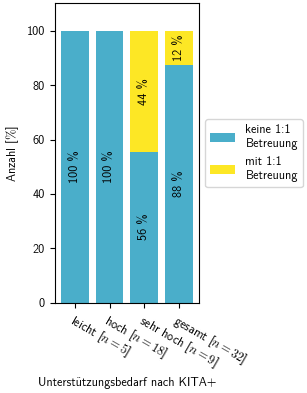

In [28]:
xValues = data["ansPerQuestion"]["suppKPlus"]
yValues = data["ansPerQuestion"]["1zu1Betr"]

values = zip(xValues,yValues)
values = list(filter(onlyValid, values))

counts = np.array([[0,0,0,0,0],   # keine
                   [0,0,0,0,0]], dtype=float)  # mit Betreuung
#                   k,l h sh gesamt

for suppKP, betr in values:
    betrIdx = 1 if betr else 0
    counts[betrIdx,suppKP-1] += 1
    counts[betrIdx, 4] += 1 # Gesamt.


# Entfernen "keine"
counts = counts[:,1:]
nPerBar = np.ndarray.sum(counts, axis=0)
percentage = counts / nPerBar * 100
n = len(values)

fig, ax = makeFigure(figsize=makeFigSize(7.8,10))
colors = getColorMap(2, start=0.4)
x = [1,2,3,4]

betreuung = ["keine 1:1\nBetreuung", "mit 1:1\nBetreuung"]

for betr in range(0,2):
    p = ax.bar(x, percentage[betr], width=0.8, 
           bottom=np.ndarray.sum(percentage[0:betr], axis=0),
           color=colors[betr],
           label=betreuung[betr])

    labels = [ (f"{v:.0f} %" if v else "") for v in percentage[betr] ]
    ax.bar_label(p, label_type='center',labels=labels, fontsize=9.0, rotation=90)

ax.set_ylabel('Anzahl [$\%$]')
ax.set_xlabel('Unterstützungsbedarf nach KITA+')
ax.set_ylim((0,110))

if withTitle:
    ax.set_title(f'Unterstützungsbedarf vs.\n1:1 Betreuung [$n={n}$]')
ax.set_xticks(x, 
    labels=[
        f'leicht [$n={int(nPerBar[0])}$]', 
        f'hoch [$n={int(nPerBar[1])}$]', 
        f'sehr hoch [$n={int(nPerBar[2])}$]',
        f'gesamt [$n={int(nPerBar[3])}$]'], 
    **ticksRotation)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

saveFig(fig, "UnterstützungsbedarfKPlusVs1zu1.pdf")

## Finanzierung 

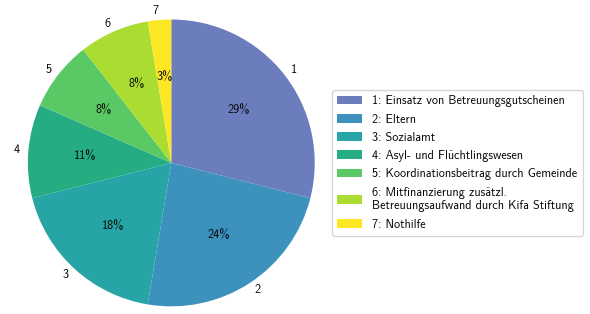

In [29]:
xValues = data["ansPerQuestion"]["finanz"]
xValues = list(itertools.chain(*xValues))

count = {}
for x in xValues:
    if x not in count:
        count[x] = 0
    count[x] += 1

count = sorted(list(count.items()), key=lambda x: x[1], reverse=True)

labels = [ data["finanzKlassen"][str(finanz)] for finanz, _ in count ]
labels = [ f"{i+1}: {l}" for i, l in enumerate(labels)]

xValues = [ c for _, c in count ]
colors = getColorMap(len(xValues))

del fig
fig, ax = makeFigure(figsize=makeFigSize(15.0,8))
fig.set_constrained_layout(False)
ax.pie(xValues, colors=colors, 
       labels=range(1,len(xValues)+1), labeldistance=1.06, 
       startangle=90, counterclock=False,
       autopct = '%.0f%%', pctdistance=0.6, textprops={'fontsize': 9})


if withTitle:
    ax.set_title(f'Wie wird die Kita finanziert?')

leg = ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1.04, 0.5))
adjustPie(fig,ax,leg)

saveFig(fig, "FinanzierungKita.pdf")

## Wohnregion


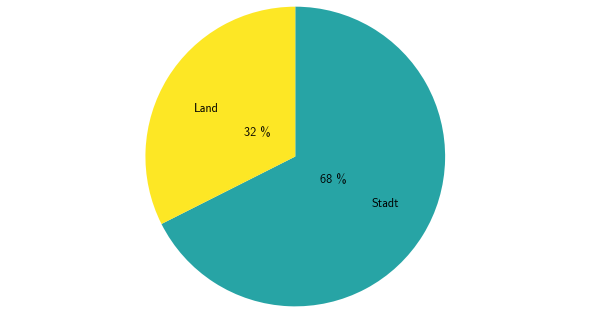

In [30]:
colors = getColorMap(10)
colors = [colors[3], colors[-1]]

fig, ax = makeFigure(figsize=makeFigSize(15.0,8))
fig.set_constrained_layout(False)

ax.pie([25,12], colors=colors, 
       labels=["Stadt", "Land"], labeldistance=0.6,
       startangle=90, counterclock=False,
       autopct = '%.0f %%', pctdistance=0.3, textprops={'fontsize': 9})

if withTitle:
    ax.set_title(f'Wohnregion der Kinder?')

# ax.legend(loc='lower center', ncol=2)
adjustPie(fig,ax, None)

saveFig(fig, "Wohnregion.pdf")

## Erstsprache

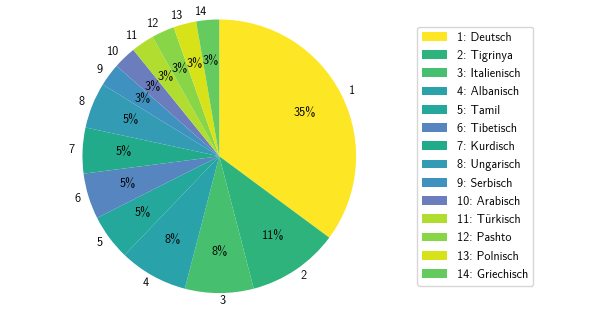

In [31]:
xValues = data["ansPerQuestion"]["erstsprache"]
xValues = list(itertools.chain(*xValues))

count = {}
for x in xValues:
    if x not in count:
        count[x] = 0
    count[x] += 1

count = sorted(list(count.items()), key=lambda x: x[1], reverse=True)

labels = [ data["erstspracheKlassen"][str(erstsprache)] for erstsprache, _ in count ]
labels = [ f"{i+1}: {l}" for i, l in enumerate(labels)]

xValues = [ c for _, c in count ]
colors = getColorMap(len(xValues), shuffle=457645)
#colors.reverse()

fig, ax = makeFigure(figsize=makeFigSize(15.0,8))
fig.set_constrained_layout(False)
ax.pie(xValues, colors=colors, 
       labels=range(1,len(xValues)+1), labeldistance=1.06, 
       startangle=90, counterclock=False,
       autopct = '%.0f%%', pctdistance=0.7, textprops={'fontsize': 9})

if withTitle:
    ax.set_title(f'Welches ist die Erstsprache des Kindes?')

leg = ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1.2, 0.5))
adjustPie(fig,ax,leg)

saveFig(fig, "ErstspracheKind.pdf")

## Grund für Kita

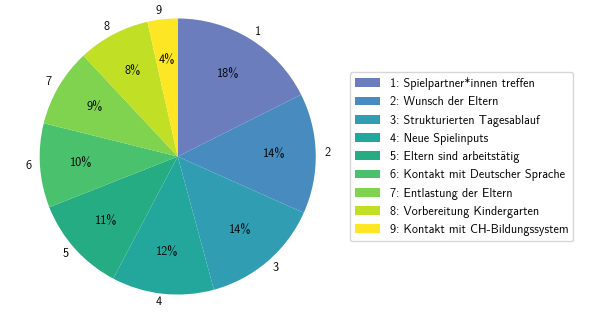

In [8]:
xValues = data["ansPerQuestion"]["grund"]
xValues = list(itertools.chain(*xValues))

count = {}
for x in xValues:
    if x not in count:
        count[x] = 0
    count[x] += 1

count = sorted(list(count.items()), key=lambda x: x[1], reverse=True)

labels = [ data["grundKlassen"][str(grund)] for grund, _ in count ]
labels = [ f"{i+1}: {l}" for i, l in enumerate(labels)]

xValues = [ c for _, c in count ]
colors = getColorMap(len(xValues))

fig, ax = makeFigure(figsize=makeFigSize(15.0,8))
fig.set_constrained_layout(False)
ax.pie(xValues, colors=colors, 
       labels=range(1,len(xValues)+1), labeldistance=1.06, 
       startangle=90, counterclock=False,
       autopct = '%.0f%%', pctdistance=0.7, textprops={'fontsize': 9})

if withTitle:
    ax.set_title(f'Gründe für den Kita Besuch')

leg = ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1.1, 0.5))
adjustPie(fig,ax,leg)

saveFig(fig, "GründeKitaBesuch.pdf")

## Hauptgrund für Kita


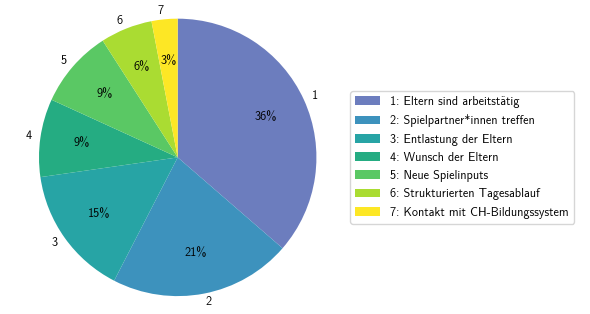

In [9]:
xValues = data["ansPerQuestion"]["hGrund"]
xValues = filter(lambda x: x is not None, xValues)


count = {}
for x in xValues:
    if x not in count:
        count[x] = 0
    count[x] += 1

count = sorted(list(count.items()), key=lambda x: x[1], reverse=True)

labels = [ data["grundKlassen"][str(hGrund)] for hGrund, _ in count ]
labels = [ f"{i+1}: {l}" for i, l in enumerate(labels)]

xValues = [ c for _, c in count ]
colors = getColorMap(len(xValues))

fig, ax = makeFigure(figsize=makeFigSize(15.0,8))
fig.set_constrained_layout(False)

ax.pie(xValues, colors=colors, 
       labels=range(1,len(xValues)+1), labeldistance=1.06, 
       startangle=90, counterclock=False,
       autopct = '%.0f%%', pctdistance=0.7, textprops={'fontsize': 9})

if withTitle:
    ax.set_title(f'Welches ist der Hauptgrund für den Kita-Besuch?')

leg = ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1.1, 0.5))
adjustPie(fig,ax,leg)

saveFig(fig, "HGrundfürKitaBesuch.pdf")

## Indik. HFE

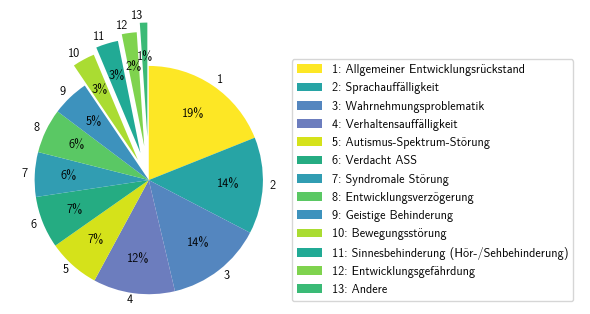

In [34]:
xValues = data["ansPerQuestion"]["indikHFE"]
xValues = list(itertools.chain(*xValues))


count = {}
for x in xValues:
    if x not in count:
        count[x] = 0
    count[x] += 1

count = sorted(list(count.items()), key=lambda x: x[1], reverse=True)

labels = [ data["indikHFHKlassen"][str(indikHFE)] for indikHFE, _ in count ]
labels = [ f"{i+1}: {l}" for i, l in enumerate(labels)]

xValues = [ c for _, c in count ]
colors = list(reversed(getColorMap(len(xValues), shuffle=23)))

fig, ax = makeFigure(figsize=makeFigSize(15.0,8))
fig.set_constrained_layout(False)
ax.pie(xValues, colors=colors, 
       explode=[0]*9 + [0.2, 0.25, 0.3, 0.38],
       labels=range(1,len(xValues)+1), labeldistance=1.06, 
       startangle=90, counterclock=False,
       autopct = '%.0f%%', pctdistance=0.7, textprops={'fontsize': 9})

if withTitle:
    ax.set_title(f'Inidikation für Heilpäd. Früherziehung')

leg = ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1.1, 0.5))
adjustPie(fig,ax,leg)

saveFig(fig, "IndikationHFE.pdf")

## Geschwisterverteilung

[[13 15  8]
 [18 15  0]
 [ 5  9  0]] 33
[[39.39393939 45.45454545 24.24242424]
 [10.94276094 27.27272727  0.        ]]


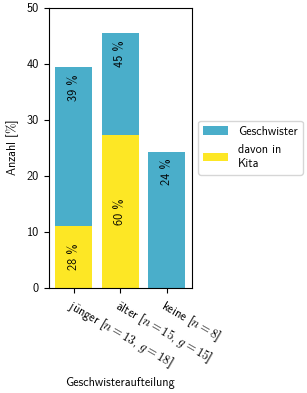

In [35]:
allSiblings = data["ansPerQuestion"]["geschwister"]

counts = np.array([[0,0,0],   # count only younger, both, only older, no siblings
                   [0,0,0],   # count siblings, 
                   [0,0,0]])  # count siblings kita

n = 0
for i,siblings in enumerate(allSiblings):
    jg = data["ansPerPerson"][i]["jahrgang"]
    

    if siblings is None:
        continue
    else:
        n += 1

    if len(siblings) == 0:
        counts[0,2] += 1
        continue
    
    hasYounger = False
    hasOlder = False
    for year,hasKita in siblings:
        if year is None:
            continue

        if year >= jg:
            hasOlder = True
            counts[1,1] += 1
            if hasKita:
                counts[2,1] += 1
        else:
            counts[1,0] += 1
            hasYounger = True
            if hasKita:
                counts[2,0] += 1

    if hasYounger: 
        counts[0,0] +=1

    if hasOlder: 
        counts[0,1] +=1

print(counts, n)

percentage = np.float_(counts)
percentage[1,0:2] = percentage[2,0:2] / percentage[1,0:2]
percentage[0] = percentage[0] / n
labelPerc = [percentage[0]*100, percentage[1]*100]

percentage[1] = percentage[1] * percentage[0]
percentage = percentage[0:2,:] * 100
print(percentage)

fig, ax = makeFigure(figsize=makeFigSize(7.8,10))
colors = getColorMap(2, start=0.4)
labels = ["Geschwister","davon in\nKita"]
x = [1,2,3]
labelType = ["edge", "center"]
padding = [-24, 0]

for idx in range(0,2):
    p = ax.bar(x, percentage[idx], width=0.8,
           color=colors[idx],
           label=labels[idx])

    l = [ (f"{v:.0f} %" if v else "") for v in labelPerc[idx] ]
    ax.bar_label(p, label_type=labelType[idx], padding=padding[idx], labels=l, fontsize=9.0, rotation=90)

ax.set_ylabel('Anzahl [$\%$]')
ax.set_xlabel('Geschwisteraufteilung')
ax.set_ylim((0,50))

if withTitle:
    ax.set_title(f'Geschwisterverteilung [$n={n}$]')
ax.set_xticks(x, labels=[f"jünger [$n={counts[0,0]}$, $g={counts[1,0]}$]", 
                         f"älter [$n={counts[0,1]}$, $g={counts[1,1]}$]", 
                         f"keine [$n={counts[0,2]}$]"], **ticksRotation)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

saveFig(fig, "Geschwister.pdf")

## Geschwister 2

[[ 8  7  9  8]
 [ 8 12 13  0]
 [ 3  7  4  0]] 32
[[25.         21.875      28.125      25.        ]
 [ 9.375      12.76041667  8.65384615  0.        ]]


/var/folders/2l/9h656ymn2f1ddsym225wf6fr0000gn/T/ipykernel_26240/396314546.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize,


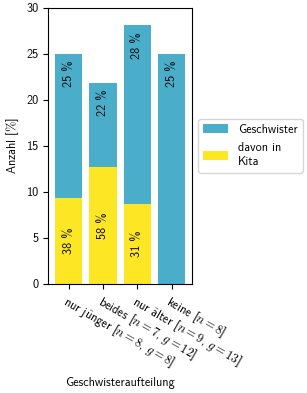

In [36]:
allSiblings = data["ansPerQuestion"]["geschwister"]

counts = np.array([[0,0,0,0],   # count only younger, both, only older, no siblings
                   [0,0,0,0],   # count siblings, 
                   [0,0,0,0]])  # count siblings kita


for i,siblings in enumerate(allSiblings):
    jg = data["ansPerPerson"][i]["jahrgang"]
    
    hasYounger = False
    hasOlder = False

    if siblings is None:
        continue
    
    if len(siblings) == 0:
        counts[0,3] += 1
        continue
    
    siblings = list(filter(lambda x: x[0] is not None, siblings))
    if len(siblings) == 0:
        # no valid siblings left... skip
        continue

    years =  [ year for year, _ in siblings ]

    nSiblings = len(siblings)
    nSiblingsKita = len(list(filter(lambda x: x[1] == True, siblings)))

    if jg > max(years):
        counts[0,2] += 1
        counts[1,2] += nSiblings
        counts[2,2] += nSiblingsKita

    elif jg < min(years):
        counts[0,0] += 1
        counts[1,0] += nSiblings
        counts[2,0] += nSiblingsKita
    else:
        counts[0,1] += 1  
        counts[1,1] += nSiblings
        counts[2,1] += nSiblingsKita

n = np.sum(counts[0,:])
print(counts, n)


percentage = np.float_(counts)
percentage[1,0:3] = percentage[2,0:3] / percentage[1,0:3]
percentage[0] = percentage[0] / n
labelPerc = [percentage[0]*100, percentage[1]*100]

percentage[1] = percentage[1] * percentage[0]
percentage = percentage[0:2,:] * 100
print(percentage)

fig, ax = makeFigure(figsize=makeFigSize(7.8,10))
colors = getColorMap(2, start=0.4)
labels = ["Geschwister","davon in\nKita"]
x = [1,2,3,4]
labelType = ["edge", "center"]
padding = [-24, 0]

for idx in range(0,2):
    p = ax.bar(x, percentage[idx], width=0.8,
           color=colors[idx],
           label=labels[idx])

    l = [ (f"{v:.0f} %" if v else "") for v in labelPerc[idx] ]
    ax.bar_label(p, label_type=labelType[idx], 
                 padding=padding[idx], labels=l, fontsize=9.0, rotation=90)

ax.set_ylabel('Anzahl [$\%$]')
ax.set_xlabel('Geschwisteraufteilung')
ax.set_ylim((0,30))

if withTitle:
    ax.set_title(f'Geschwisterverteilung [$n={n}$]')
ax.set_xticks(x, labels=[f"nur jünger [$n={counts[0,0]}$, $g={counts[1,0]}$]", 
                         f"beides [$n={counts[0,1]}$, $g={counts[1,1]}$]", 
                         f"nur älter [$n={counts[0,2]}$, $g={counts[1,2]}$]", 
                         f"keine [$n={counts[0,3]}$]"], **ticksRotation)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

saveFig(fig, "Geschwister2.pdf")

In [ ]:
xValues = data["ansPerQuestion"]["kitaVorHFE"]
xValuesJa = [ x[1] for x in filter(lambda x: x and x[0], xValues)]
countJa = len(xValuesJa)

xValuesNein = [ x[1] for x in filter(lambda x: x and not x[0], xValues)]
countNein = len(xValuesNein)

jaNeinRatios = [ countNein / (countJa + countNein), 
                 countJa / (countJa + countNein) ]

xValuesNein = list(itertools.chain(*xValuesNein))
xValuesJa = list(itertools.chain(*xValuesJa))

count = [{}, {}]

for i, values in enumerate([xValuesNein, xValuesJa]):

    for x in values:
        if x not in count[i]:
            count[i][x] = 0
        count[i][x] += 1

print(count[0])
count = [ sorted(list(count[0].items()), key=lambda x: x[1], reverse=True),
           sorted(list(count[1].items()), key=lambda x: x[1], reverse=True) ]

labels = [ "Nein - " + data["kitaVorHFE-Nein"][str(k)] for k, _ in count[0] ] + \
         [ "Ja - " + data["kitaVorHFE-Ja"][str(k)] for k, _ in count[1] ]

xValues = [ np.array([ c for _, c in count[0] ], dtype=float), 
            np.array([ c for _, c in count[1] ], dtype=float)]

for i in range(0,2):
    total = sum(xValues[i])
    xValues[i] = xValues[i] / total * jaNeinRatios[i]

xValues[0] = list(xValues[0])
xValues[1] = list(xValues[1])


colors = getColorMap(10)
colors = colors[0:len(xValues[0])] + colors[-len(xValues[1]):]
print(len(colors))
xValues = xValues[0]  + xValues[1]


labelIdx = 0
def makePercLable(x):
    global labelIdx
    if labelIdx < len(count[0]):
        x = x / jaNeinRatios[0]
    else:
        x = x / jaNeinRatios[1]
    labelIdx += 1
    return f"{x:0.0f}%"


fig, ax = makeFigure(figsize=makeFigSize(15.0,8))
fig.set_constrained_layout(False)
ax.pie(xValues, colors=colors, 
       explode=[0]*4 + [0.05]*3,
       labels=range(1,len(xValues)+1), labeldistance=1.1, 
       startangle=90, counterclock=False,
       autopct = makePercLable, pctdistance=0.8, textprops={'fontsize': 9})

if withTitle:
    ax.set_title(f'Ist Kita vor Aufnahme HFE besucht worden [{jaNeinRatios[0]*100:0.0f} %,{jaNeinRatios[1]*100:0.0f} %]?')

leg = ax.legend(labels=[ f"{i+1}: " + l for i, l in enumerate(labels) ], loc='center left', bbox_to_anchor=(1.04, 0.5))
adjustPie(fig,ax,leg)

saveFig(fig, "KitaVorHFE.pdf")

{1: 7, 2: 11, 4: 1, 3: 1}
7


[[ 0.  6. 15.  4. 25.]
 [ 0.  1.  0.  3.  4.]]


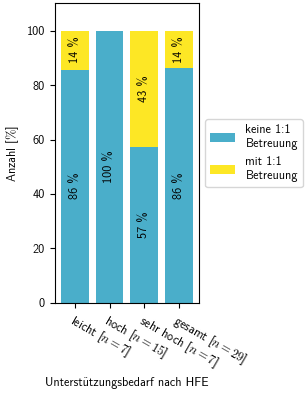

In [38]:
# Einschätzung des Unterstützungsbedarf von der HFE

xValues = data["ansPerQuestion"]["suppHFE"]
yValues = data["ansPerQuestion"]["1zu1Betr"]

values = zip(xValues,yValues)
values = list(filter(onlyValid, values))

counts = np.array([[0,0,0,0,0],   # keine
                   [0,0,0,0,0]], dtype=float)  # mit Betreuung
#                   k,l h sh gesamt

for suppHFEs, betr in values:
    betrIdx = 1 if betr else 0

    for suppHFE in suppHFEs:
        counts[betrIdx,suppHFE-1] += 1.0/len(suppHFEs)

    counts[betrIdx, 4] += 1 # Gesamt.

print(counts)

# Entfernen "keine"
counts = counts[:,1:]
nPerBar = np.ndarray.sum(counts, axis=0)
percentage = counts / nPerBar * 100
n = len(values)

fig, ax = makeFigure(figsize=makeFigSize(7.8,10))
colors = getColorMap(2, start=0.4)
x = [1,2,3,4]

betreuung = ["keine 1:1\nBetreuung", "mit 1:1\nBetreuung"]

for betr in range(0,2):
    p = ax.bar(x, percentage[betr], width=0.8, 
           bottom=np.ndarray.sum(percentage[0:betr], axis=0),
           color=colors[betr],
           label=betreuung[betr])

    labels = [ (f"{v:.0f} %" if v else "") for v in percentage[betr] ]
    ax.bar_label(p, label_type='center',labels=labels, fontsize=9.0, rotation=90)

ax.set_ylabel('Anzahl [$\%$]')
ax.set_xlabel('Unterstützungsbedarf nach HFE')
ax.set_ylim((0,110))

if withTitle:
    ax.set_title(f'Unterstützungsbedarf HFE vs.\n1:1 Betreuung [$n={n}$]')
ax.set_xticks(x, 
    labels=[
        f'leicht [$n={nPerBar[0]:0.0f}$]', 
        f'hoch [$n={nPerBar[1]:0.0f}$]', 
        f'sehr hoch [$n={nPerBar[2]:0.0f}$]',
        f'gesamt [$n={nPerBar[3]:0.0f}$]'], 
    **ticksRotation)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

saveFig(fig, "UnterstützungsbedarfHFEVs1zu1.pdf")




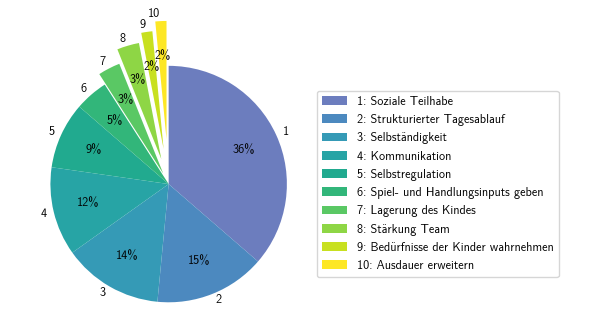

In [39]:
# Hauptanliegen der Kitas

xValues = data["ansPerQuestion"]["hProblem"]
xValues = list(itertools.chain(*xValues))

count = {}
for x in xValues:
    if x not in count:
        count[x] = 0
    count[x] += 1

count = sorted(list(count.items()), key=lambda x: x[1], reverse=True)

labels = [ data["hProblemKlassen"][str(grund)] for grund, _ in count ]
labels = [ f"{i+1}: {l}" for i, l in enumerate(labels)]

xValues = [ c for _, c in count ]
colors = getColorMap(len(xValues))

fig, ax = makeFigure(figsize=makeFigSize(15.0,8))
fig.set_constrained_layout(False)
ax.pie(xValues, colors=colors, 
       explode=[0]*(len(xValues)-4) + [0.1, 0.22, 0.3, 0.38],
       labels=range(1,len(xValues)+1), labeldistance=1.06, 
       startangle=90, counterclock=False,
       autopct = '%.0f%%', pctdistance=0.7, textprops={'fontsize': 9})

if withTitle:
    ax.set_title(f'Hauptanliegen der Kitas')

leg = ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1.1, 0.5))
adjustPie(fig,ax,leg)

saveFig(fig, "HauptanliegenKitaBesuch.pdf")

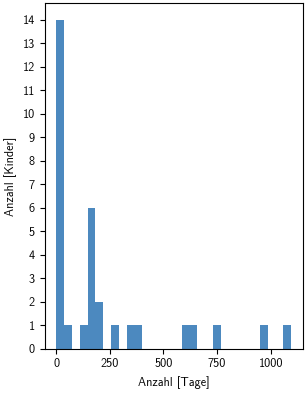

In [40]:
datesK = data["ansPerQuestion"]["startK"]
datesKP = data["ansPerQuestion"]["startKP"]

def onlyValid(e):
    return e[0] is not None and e[1] is not None
values = filter(onlyValid, zip(datesK, datesKP))

differences = [  (convertToDate(d2) - convertToDate(d1)).days for d1, d2 in values ]

x = differences
startEnd=(min(x),max(x))
n = len(x)
bins = 30
mn = mean(x)

fig, ax = makeFigure(figsize=makeFigSize(7.8, 10))
ax.hist(x, bins, color=defaultColor, range=startEnd, histtype='bar')

if withTitle:
    ax.set_title(f"KITAplus Initierung [$n={n}$, $\mu={mn:.1f}$]", fontfamily="Latin Modern Sans")
ax.set_xlabel("Anzahl [Tage]")
ax.set_ylabel("Anzahl [Kinder]")

start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end, 1))

saveFig(fig, "KitaStartbisKPlus.pdf")

[(3, 37), (4, 25), (2, 18), (0, 13), (7, 7), (8, 6), (1, 5), (6, 1)]


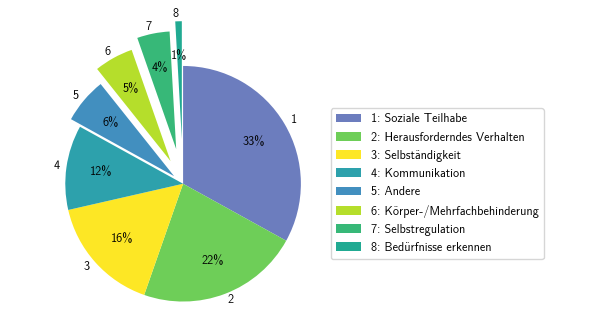

In [41]:
# Herausforderungen der Kitas

xValues = data["ansPerQuestion"]["herausforderungen"]
xValues = list(itertools.chain(*xValues))

count = {}
for x in xValues:
    if x not in count:
        count[x] = 0
    count[x] += 1

count = sorted(list(count.items()), key=lambda x: x[1], reverse=True)
print(count)

labels = [ data["herausforderungenKlassen"][str(grund)] for grund, _ in count ]
labels = [ f"{i+1}: {l}" for i, l in enumerate(labels)]

xValues = [ c for _, c in count ]
colors = getColorMap(len(xValues), shuffle=3)

fig, ax = makeFigure(figsize=makeFigSize(15.0,8))
fig.set_constrained_layout(False)
ax.pie(xValues, colors=colors, 
       explode=[0]*(len(xValues)-4) + [0.1, 0.22, 0.3, 0.38],
       labels=range(1,len(xValues)+1), labeldistance=1.06, 
       startangle=90, counterclock=False,
       autopct = '%.0f%%', pctdistance=0.7, textprops={'fontsize': 9})

if withTitle:
    ax.set_title(f'Herausforderungen der Kitas')

leg = ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1.1, 0.5))
adjustPie(fig,ax,leg)

saveFig(fig, "HerausforderungenKita.pdf")